<a href="https://colab.research.google.com/github/RoseSarlake/Computer-Vision/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import cv2
import math
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import glob

In [3]:
# need a opencv version which has SIFT and SURF
# pip uninstall opencv-python
# pip install opencv-contrib-python==4.4.0.40
# pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17
cv2.__version__

'4.4.0'

In [4]:
!python --version

Python 3.7.10


Some useful function from assignment 1

In [8]:
def My_Gaussian(size,sigma):
  w = size 
  hw = (w-1)/2
  sum = 0
  g = np.zeros(w)
  for i in range(0,w):
    # The continuous normalization factor can be ignored since it disappears in the discrete normalization step
    g[i] = math.exp(-((i-hw)*(i-hw))/(2*sigma*sigma))
    sum += g[i]
  for i in range(0,w):
    g[i] /= sum
  return g

In [9]:
def My_convolve2D(image, kernel, padding=0):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int((xImgShape - xKernShape + 2 * padding) + 1)
    yOutput = int((yImgShape - yKernShape + 2 * padding) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply mirror padding
    if padding != 0:
        imagePadded = cv2.copyMakeBorder(image,padding,padding,padding,padding,cv2.BORDER_REFLECT)
        #print(imagePadded)
    else:
        imagePadded = image

    # Convolution
    for y in range(image.shape[1]):
        for x in range(image.shape[0]):
          output[x, y] = (kernel * imagePadded[x:x+xKernShape,y:y+yKernShape]).sum()
    return output

In [10]:
def My_sampling(img,n,way):
  #re_img = cv2.resize(img,(img2a.shape[1],img2a.shape[0]),fx=2**n,fy=2**n,interpolation = cv2.INTER_CUBIC)
  if way == "up":
    re_img = cv2.resize(img,None,fx=2**n,fy=2**n,interpolation = cv2.INTER_CUBIC)
  if way == "down":
    re_img = cv2.resize(img,None,fx=1/2**n,fy=1/2**n,interpolation = cv2.INTER_CUBIC)
  return re_img

In [11]:
def My_pyrm(img,time,way):
  imgset = [img]
  sigma = 1
  for i in range(0,time):

    new = My_sampling(img,i+1,way)

    col = My_Gaussian(5,sigma)
    row = col.reshape(col.shape[0],1)
    ker = col*row
    conimg = My_convolve2D(new,ker,padding=2)
    
    imgset.append(conimg)
  return imgset

In [12]:
def My_Lappyr(img,layer):
  # Create a Gaussian Pyramid
  my_g_pyr = My_pyrm(img,layer,"down")
  # Create a Laplacian Pyramid
  laplacian_pyr = [my_g_pyr[-1]]
  for i in range(layer,0,-1):
    expand = My_pyrm(my_g_pyr[i],1,"up")
    laplacian = my_g_pyr[i-1] - expand[1]
    laplacian_pyr.append(laplacian)
  return laplacian_pyr,expand

# pre-process image mosaic 

In [4]:
# locate to images path
path = glob.glob("/content/drive/MyDrive/Colab Notebooks/image/*.jpg")
# store images in a list
images = [cv2.imread(file) for file in path]
len(images)
# create a grayscale version to detect more accurate
grayimg = images.copy()
for i in range(len(grayimg)):
  grayimg[i] = cv2.cvtColor(grayimg[i], cv2.COLOR_BGR2GRAY)

In [5]:
images[0].shape

(240, 320, 3)

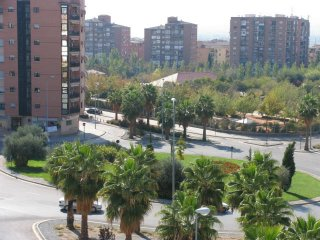

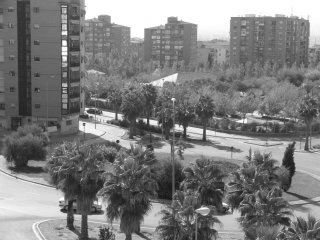

In [6]:
cv2_imshow(images[0])
cv2_imshow(grayimg[0])

# Extract features 

In [11]:
def MyFeature(inputlist):
  # keypoints and descriptions in each images
  kp = [None] * len(inputlist)
  des = [None] * len(inputlist)
  # create SIFT object
  sift = cv2.SIFT_create()

  for i in range(len(inputlist)):
    # detect and compute the key points
    kp[i], des[i] = sift.detectAndCompute(inputlist[i],None)
  return kp,des

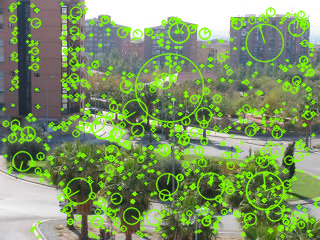

In [13]:
# detect and compute the feature of all the image set
mypoints, mydes = MyFeature(grayimg)
# draw the keypoints
cv2_imshow(cv2.drawKeypoints(images[0],mypoints[0],None,(0,255,128),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

# Match features


In [24]:
def MyMatching(des):
  # create a BFMatcher object
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
  # store the matching points, the length is 1 less than description list
  matches = [None] * (len(des)-1)

  # find matching points
  for i in range(len(des)-1):
    # find matching points
    matches[i] = bf.match(des[i],des[i+1])
    #matches[I] = bf.knnMatch(des[i],des[i+1],k=3)
    # sort the keypoint by the distance
    matches[i] = sorted(matches[i], key = lambda x:x.distance)
  return matches

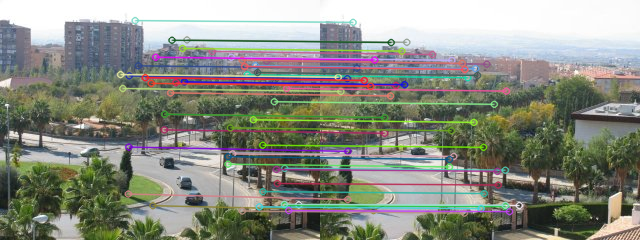

In [25]:
# compute all the matching pairs between every two neighboring images
mymatches = MyMatching(mydes)
# show one matching result, show the most strong 50 pairs
matching = cv2.drawMatches(images[4],mypoints[4],images[5],mypoints[5],mymatches[4][:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2_imshow(matching)

In [26]:
def MyPairs(matches,kps):
  # two list to store each matching matrix
  left = []
  right = []
  # store the mathcing points into left and right matrix
  for i in range(len(matches)):
    # two matrix to store matching point information 
    p_left = np.zeros((len(matches[i]), 2))
    p_right = np.zeros((len(matches[i]), 2))
    # locate every matching points
    for j in range(len(matches[i])):
      p_left[j,:] = kps[i][matches[i][j].queryIdx].pt
      p_right[j,:] = kps[i+1][matches[i][j].trainIdx].pt
    # add to the prepared list
    left.append (p_left)
    right.append (p_right)
  return left,right


In [27]:
# store all the locations for every pairs in every two adjacent images
myleft,myright = MyPairs(mymatches,mypoints)
# check the length
print(len(myleft[5]))
print(len(myright[5]))

428
428


# Compute a homography using RANSAC

In [21]:
def MyHomography(ref,tra):
  # generate the homography list and mask list
  H = [None] * len(ref)
  mask = [None] * len(ref)
  # compute the homagrapgy using RANSAC
  for i in range(len(ref)):
    H[i], mask[i] = cv2.findHomography(ref[i], tra[i], cv2.RANSAC,1.0)
  return H,mask

In [22]:
myhomo, mymask = MyHomography(myleft,myright)

In [164]:
myhomo[0]

array([[ 1.05695935e+00,  7.95590103e-03, -7.42689529e+01],
       [ 1.36423750e-02,  1.03317439e+00, -7.46484179e-01],
       [ 1.64637114e-04, -2.42128399e-06,  1.00000000e+00]])

In [182]:
myhomo[1]

array([[ 1.04988807e+00,  7.77077876e-03, -6.52955860e+01],
       [ 1.08610910e-02,  1.02819856e+00, -9.26638338e-02],
       [ 1.43436745e-04, -2.55720971e-06,  1.00000000e+00]])

In [188]:
m02=myhomo[0]+myhomo[1]
myhomo[0]*myhomo[1]

array([[1.10968901e+00, 6.18235468e-05, 4.84943480e+03],
       [1.48171077e-04, 1.06230842e+00, 6.91720859e-02],
       [2.36150117e-08, 6.19173093e-12, 1.00000000e+00]])

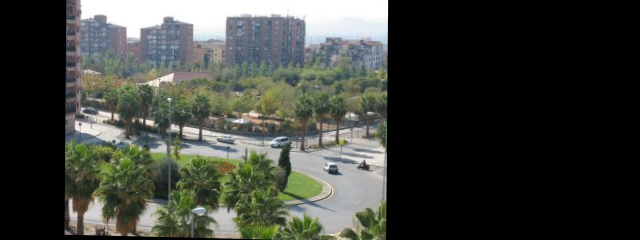

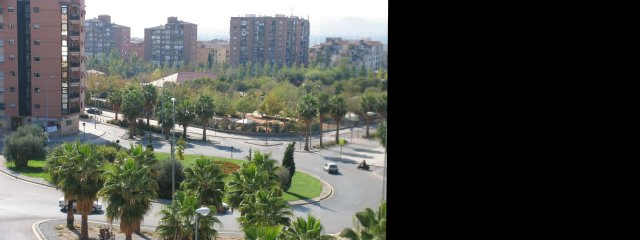

In [190]:
 warpImgn = cv2.warpPerspective(images[1], np.linalg.inv(m02), (images[0].shape[1]+images[1].shape[1], images[1].shape[0]))
 cv2_imshow(warpImgn)
 directn=warpImgn.copy()
 directn[0:images[0].shape[0], 0:images[0].shape[1]] =images[0]
 cv2_imshow(directn)

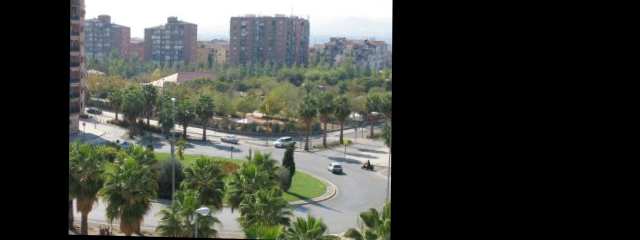

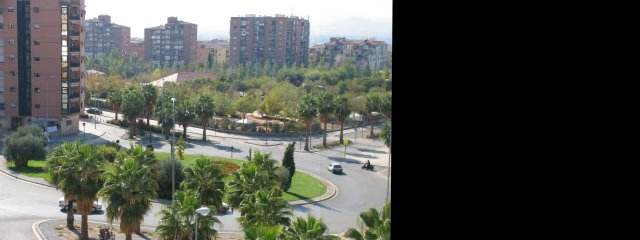

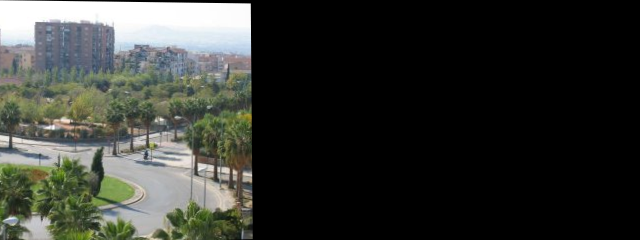

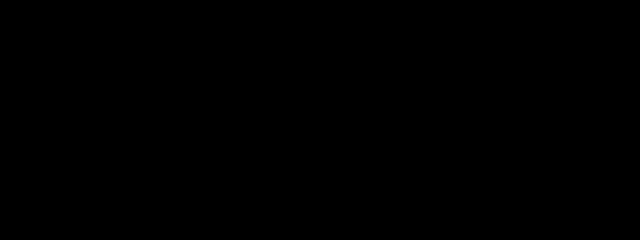

In [195]:
 warpImg = cv2.warpPerspective(images[1], np.linalg.inv(myhomo[0]), (images[0].shape[1]+images[1].shape[1], images[1].shape[0]))
 cv2_imshow(warpImg)
 warpImg[0:images[0].shape[0], 0:images[0].shape[1]] =images[0]
 cv2_imshow(direct)
 h13= myhomo[0] * myhomo[1]
 warpImg2 = cv2.warpPerspective(images[2], myhomo[0], (images[1].shape[1]+images[2].shape[1], images[2].shape[0]))
 cv2_imshow(warpImg2)
 warpImg3 = cv2.warpPerspective(images[2], np.linalg.inv(h13), (images[1].shape[1]+images[2].shape[1], images[2].shape[0]))
 cv2_imshow(warpImg3)

In [128]:
print(myhomo[0])
print(np.linalg.inv(myhomo[0]))
print(myhomo[1])
print(np.linalg.inv(myhomo[1]))
print(myhomo[1]*myhomo[0])
print(np.linalg.inv(myhomo[1]*myhomo[0]))
print(np.multiply(np.linalg.inv(myhomo[0]),np.linalg.inv(myhomo[1])))

[[ 1.05695935e+00  7.95590103e-03 -7.42689529e+01]
 [ 1.36423750e-02  1.03317439e+00 -7.46484179e-01]
 [ 1.64637114e-04 -2.42128399e-06  1.00000000e+00]]
[[ 9.35380921e-01 -7.04005522e-03  6.94645062e+01]
 [-1.24623658e-02  9.67986306e-01 -2.02980399e-01]
 [-1.54028590e-04  3.50282412e-06  9.88563073e-01]]
[[ 1.04988807e+00  7.77077876e-03 -6.52955860e+01]
 [ 1.08610910e-02  1.02819856e+00 -9.26638338e-02]
 [ 1.43436745e-04 -2.55720971e-06  1.00000000e+00]]
[[ 9.44132435e-01 -6.98211430e-03  6.16470336e+01]
 [-9.98528874e-03  9.72648858e-01 -5.61865908e-01]
 [-1.35448818e-04  3.48875885e-06  9.91156113e-01]]
[[1.10968901e+00 6.18235468e-05 4.84943480e+03]
 [1.48171077e-04 1.06230842e+00 6.91720859e-02]
 [2.36150117e-08 6.19173093e-12 1.00000000e+00]]
[[ 9.01246391e-01 -5.24246879e-05 -4.37053561e+03]
 [-1.25704714e-04  9.41346214e-01  5.44481933e-01]
 [-2.12829433e-08 -4.59055285e-12  1.00010321e+00]]
[[8.83123467e-01 4.91544703e-05 4.28228075e+03]
 [1.24440321e-04 9.41510775e-01 1.140

In [ ]:
images[1].shape[0]


In [44]:
width = images[0].shape[1] + images[1].shape[1]
height = images[0].shape[0] + images[1].shape[0]
height, width = images[1].shape
result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

ValueError: ignored

# Align images

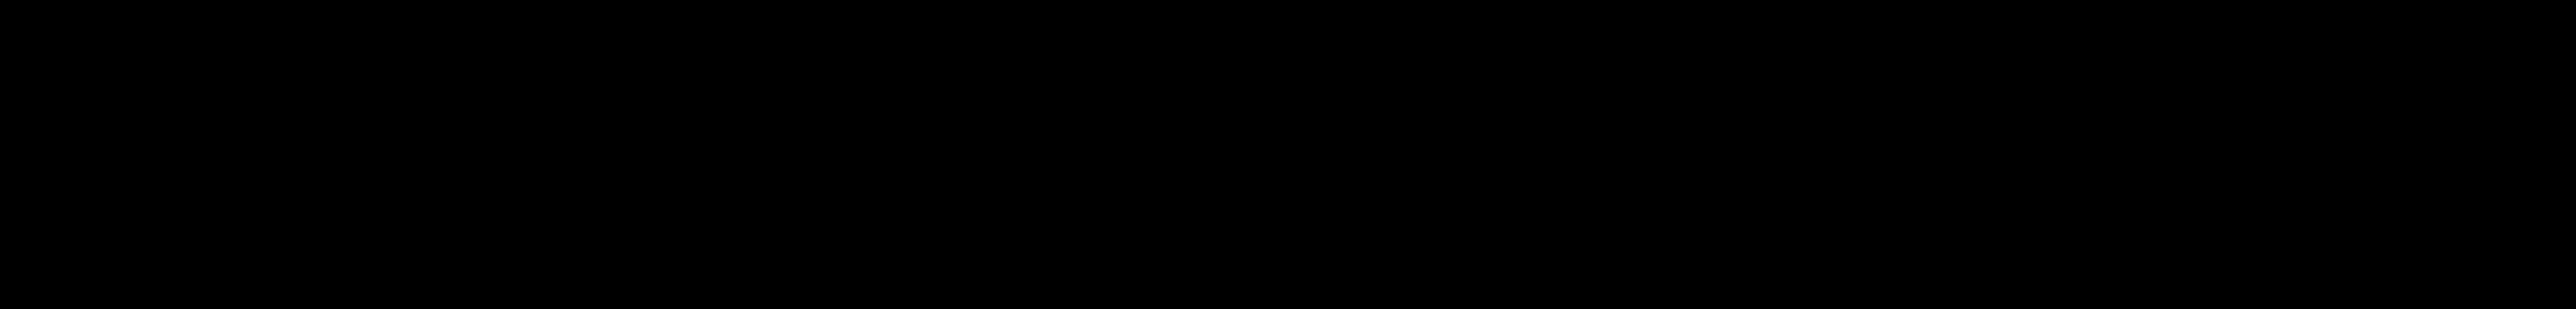

In [196]:
# create a big enough canvas
canvas = np.zeros((360, 3000, 3),np.uint8)
cv2_imshow(canvas)

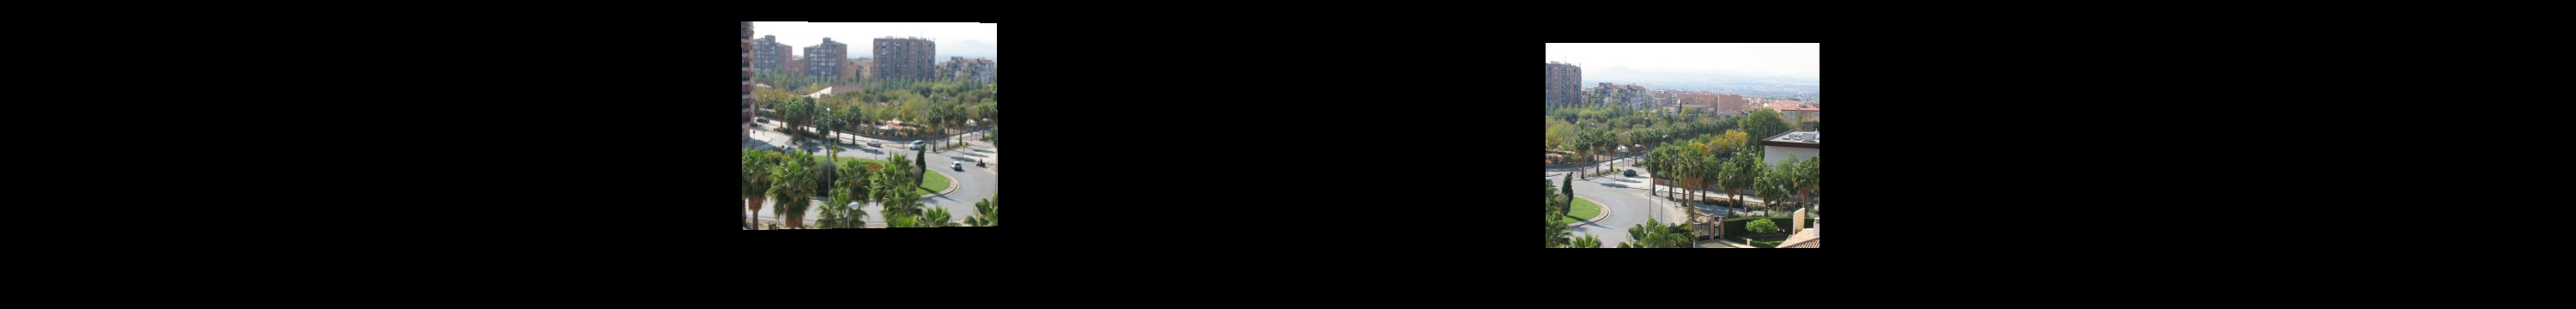

In [181]:
 H2= myhomo[0]+h
 warpImg = cv2.warpPerspective(images[1], H2, (canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
 cv2_imshow(warpImg)

(240, 320, 3)


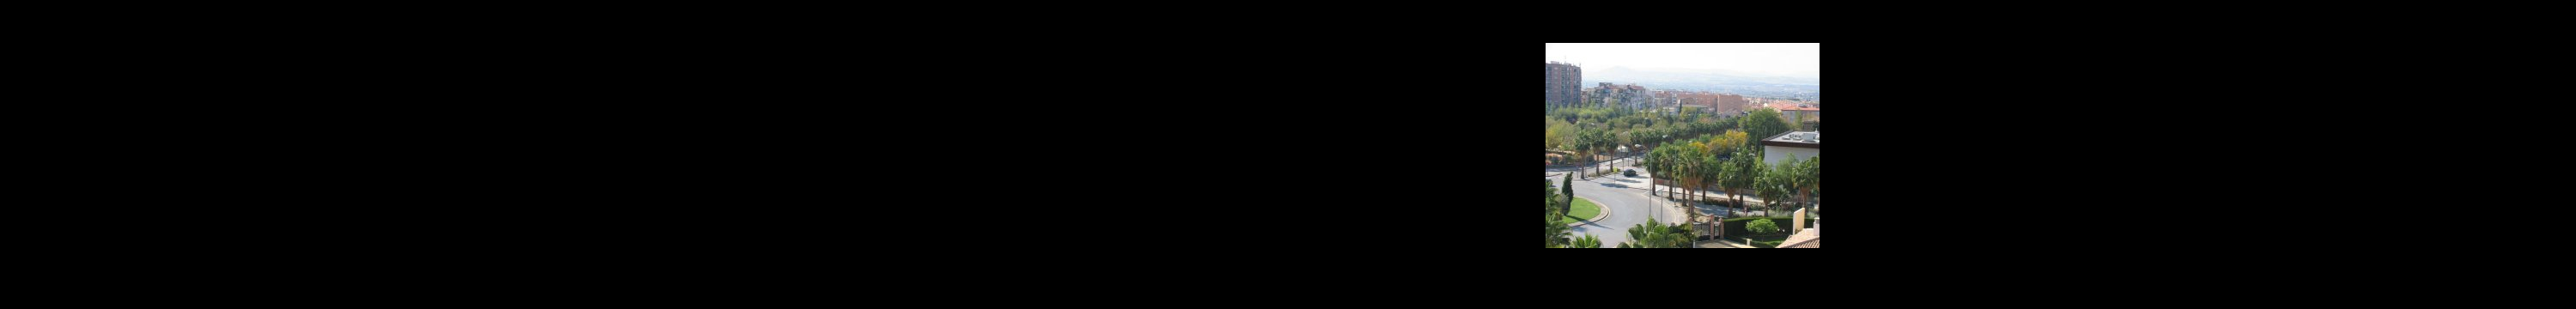

In [178]:
# middle image size
print(images[5].shape)
# define the 4 corner points of the original and the location in canvas
pts1 = np.array([[0,0],[320,0],[0,240],[320,240]])
pts2 = np.array([[1800,50],[2120,50],[1800,290],[2120,290]])
# find the homography between the middle image and canvas, here is a translation
h, status = cv2.findHomography(pts1, pts2, cv2.RANSAC,1.0)
# move the middle image to canvas
temp = cv2.warpPerspective(images[5], h, (canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT) 
cv2_imshow(temp)

In [32]:
homo56 = myhomo[5]*(h)

In [67]:
np.linalg.inv(myhomo[5])*h

array([[ 9.39747454e-01, -0.00000000e+00,  1.18971793e+05],
       [-0.00000000e+00,  9.71327741e-01, -3.28252764e+01],
       [-0.00000000e+00,  0.00000000e+00,  9.89698981e-01]])

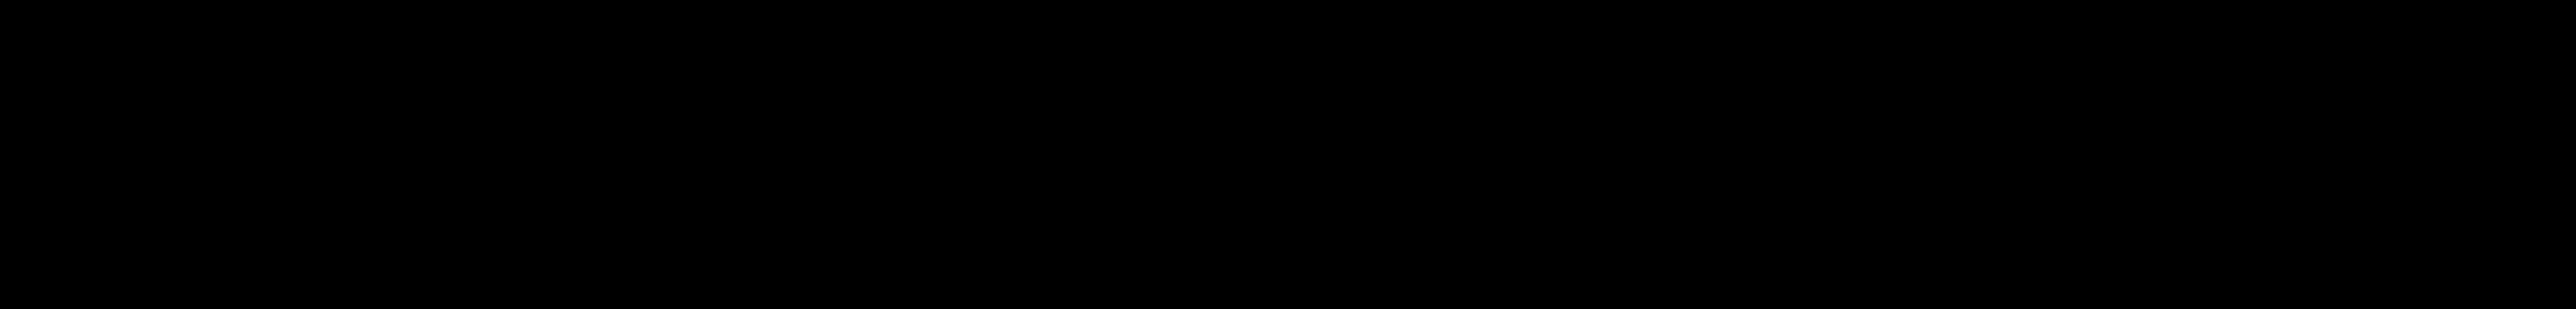

In [197]:
 warpImg = cv2.warpPerspective(images[6], h*np.linalg.inv(myhomo[5]),(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
 cv2_imshow(warpImg)
 direct=warpImg.copy()
 #re = cv2.warpPerspective(images[5], h, (canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)   
 #direct[0:images[0].shape[0], 0:images[0].shape[1]] =images[0]
 #cv2_imshow(re)

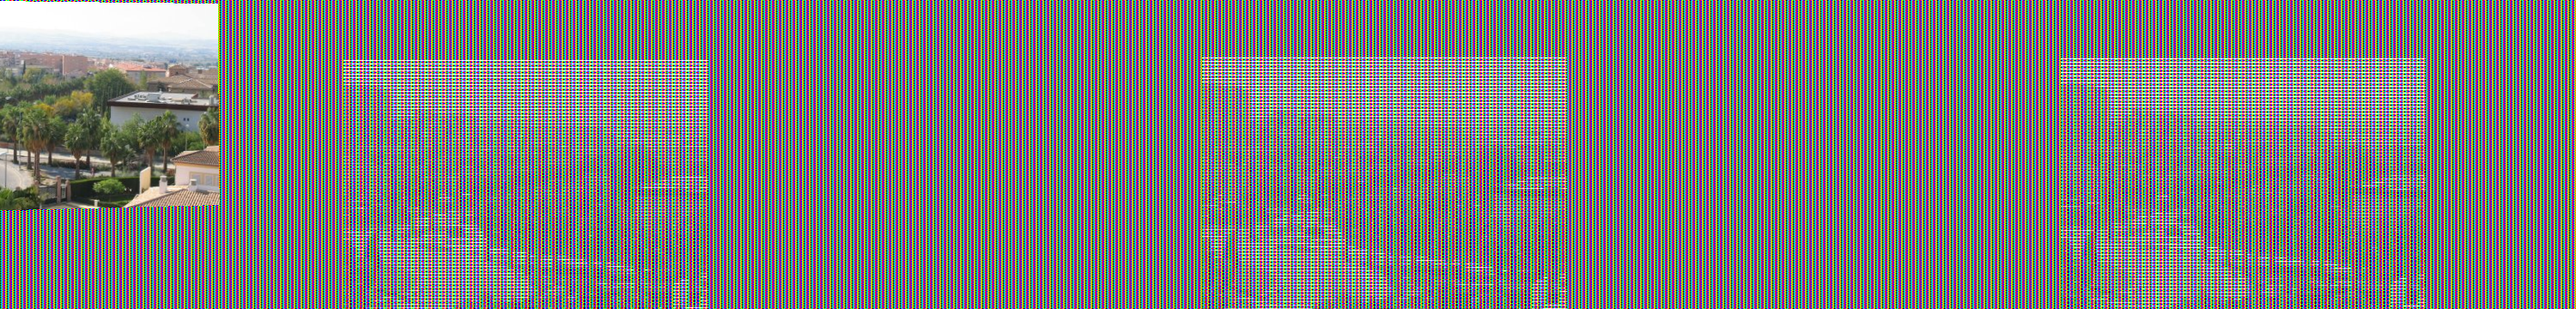

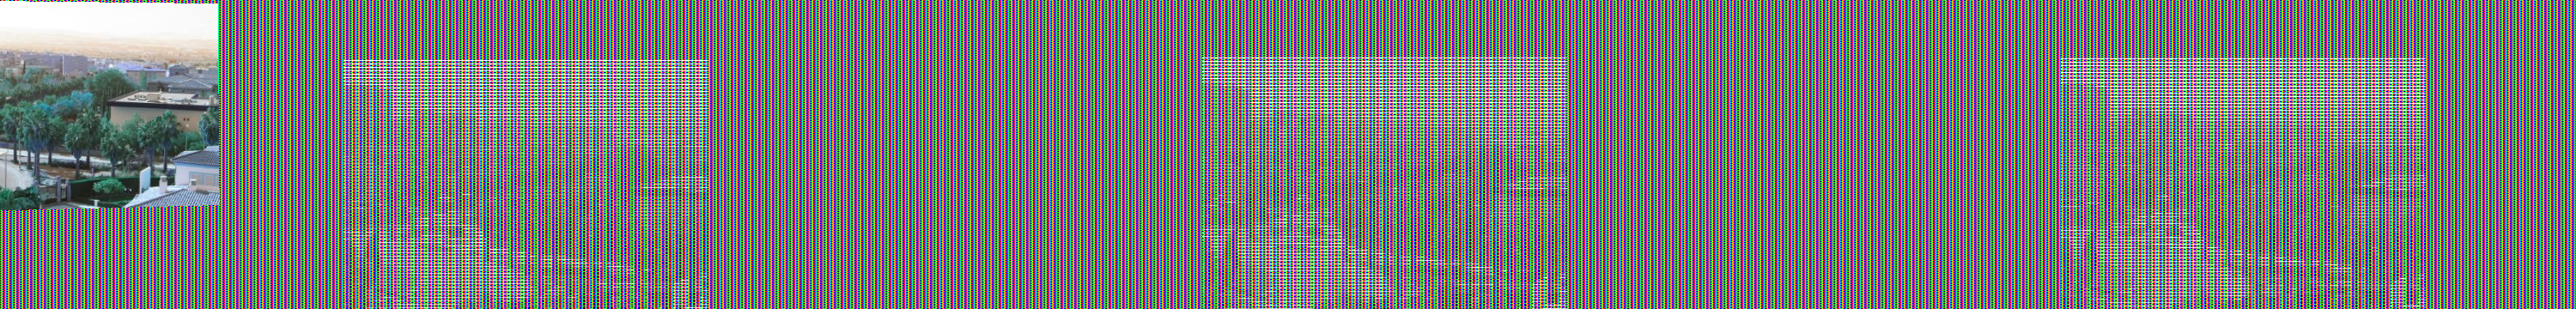

In [33]:
temp = cv2.warpPerspective(images[6], myhomo[5],(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
cv2_imshow(temp)
temp2 = cv2.warpPerspective(images[6], myhomo[5]*h,(canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
cv2_imshow(temp2)
#temp2 [0:images[6].shape[0], 0:images[6].shape[1]] = images[6]
#cv2_imshow(temp2)
#new = cv2.warpPerspective(temp2, h, (canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT) 
#cv2_imshow(new)

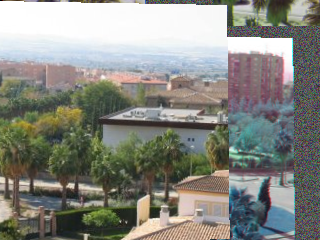

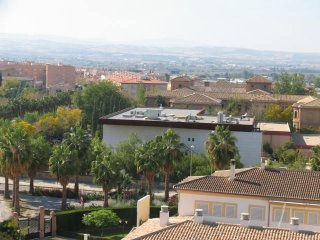

In [34]:
temp3 = cv2.warpPerspective(images[6], myhomo[6], (images[7].shape[1], images[7].shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
cv2_imshow(temp3)
temp3[0:images[7].shape[0], 0:images[7].shape[1]] = images[7]
cv2_imshow(temp3)
#new3 = cv2.warpPerspective(temp2, h, (canvas.shape[1],canvas.shape[0]),borderMode=cv2.BORDER_TRANSPARENT) 
#cv2_imshow(new3)

In [ ]:
def My_convColor(image, kernel, padding=0):
  blue = My_convolve2D(A[:,:,0], kernel, padding)
  green = My_convolve2D(A[:,:,1], kernel, padding)
  red = My_convolve2D(A[:,:,2], kernel, padding)
  merged = cv2.merge([blue, green, red])
  return merged

In [ ]:
import cv2
import numpy as np,sys
import sys

A = cv2.imread("/content/drive/MyDrive/Colab Notebooks/image/mosaico002.jpg")
B = cv2.imread("/content/drive/MyDrive/Colab Notebooks/image/mosaico006.jpg")
blueA = A[:,:,0]
greenA = A[:,:,1]
redA = A[:,:,2]
blueB = B[:,:,0]
greenB = B[:,:,1]
redB = B[:,:,2]

gpA_blue = My_pyrm(blueA,4,"down")
gpB_blue = My_pyrm(blueB,4,"down")
[lpA_blue,expA_blue] = My_Lappyr(blueA,4)
[lpB_blue,expB_blue] = My_Lappyr(blueB,4)

# LS = []
# for la,lb in zip(lpA,lpB):
#     rows,cols,dpt = la.shape
#     ls = np.hstack((la[:,0:cols/2], lb[:,cols/2:]))
#     LS.append(ls)

# # now reconstruct
# ls_ = LS[0]
# for i in range(1,6):
#     ls_ = cv2.pyrUp(ls_)
#     ls_ = cv2.add(ls_, LS[i])

# # image with direct connecting each half
# real = np.hstack((A[:,:cols/2],B[:,cols/2:]))

# cv2_imshow(ls_)
# cv2_imshow(real)

In [ ]:
LS = []
for la,lb in zip(lpA_blue,lpB_blue):
    rows,cols = la.shape
    ls = np.hstack((la[:,0:int(cols/2)], lb[:,int(cols/2):]))
    LS.append(ls)

for i in range (1,len(LS)):
    plt.subplot(2,2,i)
    plt.imshow(LS[i])

In [ ]:
real = np.hstack((A[:,:int(cols/2)],B[:,int(cols/2):]))
cv2_imshow(real)
dir = np.hstack((A_blue[1][:,:int(cols/2)],B_blue[1][:,int(cols/2):]))
cv2_imshow(dir)

In [ ]:
# now reconstruct
ls_ = LS[0]

rec = My_pyrm(LS[0],4,"up")
    #ls_ = cv2.pyrUp(ls_)
recover1 = LS[4]+rec[4]
cv2_imshow(recover1)
dir = np.hstack((blueA[:,:int(cols/2)],blueB[:,int(cols/2):]))
cv2_imshow(dir)

In [ ]:
len(rec)

In [ ]:
for i in range (1,len(lpA_blue)):
    plt.subplot(2,2,i)
    plt.imshow(lpA_blue[i])